# Beehive Unified Pipeline (03–04)

One notebook to load → clean → validate labels → (optional) EDA → (optional) window features.

**No extra files are written by default.**

**Source CSV path:** `/mnt/data/BeeHive_audio_updated.csv`

## Queen fields (ground truth mapping)
- **queen_acceptance**:
  - 0 = no queen present
  - 1 = not accepted / rejected
  - 2 = accepted

- **queen_status** (combined summary):
  - 0 = queenright / original queen
  - 1 = not present
  - 2 = present and rejected
  - 3 = present and newly accepted

> `queen_status` is not a strict function of (`queen_presence`, `queen_acceptance`).
We validate using allowed sets rather than a single mapping.

## 1) Imports

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 2000)

CSV_PATH = Path('Datasets/BeeHive_audio_updated.csv')
assert CSV_PATH.exists(), f'Expected CSV at {CSV_PATH} was not found.'

## 2) Load raw CSV

In [5]:
# Load with low_memory=False to avoid dtype heuristics
df_raw = pd.read_csv(CSV_PATH, sep=',', dtype=str, low_memory=False)

print('Raw shape:', df_raw.shape)
print('Raw columns:', list(df_raw.columns))
display(df_raw.head(3))

Raw shape: (1275, 23)
Raw columns: ['device', 'hive number', 'date', 'hive temp', 'hive humidity', 'hive pressure', 'weather temp', 'weather humidity', 'weather pressure', 'wind speed', 'gust speed', 'weatherID', 'cloud coverage', 'rain', 'lat', 'long', 'file name', 'queen presence', 'queen acceptance', 'frames', 'target', 'time', 'queen status']


,device,hive number,date,hive temp,hive humidity,hive pressure,weather temp,weather humidity,weather pressure,wind speed,gust speed,weatherID,cloud coverage,rain,lat,long,file name,queen presence,queen acceptance,frames,target,time,queen status
0,1,5,2022-06-08 14:52:28,36.42,30.29,1007.45,26.68,52,1013,8.75,NaN,711,75,0,37.29,-121.95,2022-06-08--14-52-28_1.raw,1,2,8,0,0.583,0
1,1,5,2022-06-08 15:51:41,33.56,33.98,1006.93,25.99,53,1012,10.29,NaN,803,75,0,37.29,-121.95,2022-06-08--15-51-41_1.raw,1,2,8,0,0.625,0
2,1,5,2022-06-08 17:21:53,29.01,42.73,1006.68,24.49,56,1012,8.75,NaN,803,75,0,37.29,-121.95,2022-06-08--17-21-53_1.raw,0,0,8,1,0.708,1


## 3) Standardize column names & dtypes

In [6]:
rename_map = {
    'device': 'device',
    'hive number': 'hive_number',
    'date': 'timestamp',
    'hive temp': 'hive_temp',
    'hive humidity': 'hive_humidity',
    'hive pressure': 'hive_pressure',
    'weather temp': 'weather_temp',
    'weather humidity': 'weather_humidity',
    'weather pressure': 'weather_pressure',
    'wind speed': 'wind_speed',
    'gust speed': 'gust_speed',
    'weatherID': 'weather_id',
    'cloud coverage': 'cloud_coverage',
    'rain': 'rain',
    'lat': 'lat',
    'long': 'lon',
    'file name': 'file_name',
    'queen presence': 'queen_presence',
    'queen acceptance': 'queen_acceptance',
    'frames': 'frames',
    'target': 'target',
    'time': 'time_fraction',
    'queen status': 'queen_status',
}

df = df_raw.rename(columns={k: v for k, v in rename_map.items() if k in df_raw.columns})

# Parse timestamp (US style month/day)
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce', infer_datetime_format=True)

# Coerce numerics
num_cols_possible = [
    'device','hive_number','hive_temp','hive_humidity','hive_pressure',
    'weather_temp','weather_humidity','weather_pressure','wind_speed','gust_speed',
    'weather_id','cloud_coverage','rain','lat','lon','queen_presence','queen_acceptance',
    'frames','target','time_fraction','queen_status'
]
for c in num_cols_possible:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

df = df.sort_values(['device','hive_number','timestamp'], kind='mergesort').drop_duplicates()
print('Cleaned shape:', df.shape)
display(df.head(3))

Cleaned shape: (1275, 23)


C:\Users\leona\AppData\Local\Temp\ipykernel_8140\2085942357.py:30: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce', infer_datetime_format=True)


,device,hive_number,timestamp,hive_temp,hive_humidity,hive_pressure,weather_temp,weather_humidity,weather_pressure,wind_speed,gust_speed,weather_id,cloud_coverage,rain,lat,lon,file_name,queen_presence,queen_acceptance,frames,target,time_fraction,queen_status
286,1,4,2022-06-24 10:03:35,42.76,38.83,1005.69,25.03,43,1012,2.57,NaN,800,0,0,37.29,-121.95,2022-06-24--10-03-35_1.raw,1,2,8,0,0.417,0
287,1,4,2022-06-24 11:03:30,48.42,20.98,1005.54,27.45,38,1011,3.60,NaN,800,0,0,37.29,-121.95,2022-06-24--11-03-30_1.raw,1,2,8,0,0.458,0
288,1,4,2022-06-24 12:02:42,47.41,18.39,1005.24,30.37,34,1011,3.09,NaN,800,0,0,37.29,-121.95,2022-06-24--12-02-42_1.raw,1,2,8,0,0.500,0


## 4) Queen label dictionaries & readable labels

In [7]:
QUEEN_ACCEPTANCE_LABELS = {0: 'no queen present', 1: 'rejected', 2: 'accepted'}
QUEEN_STATUS_LABELS = {0: 'queenright/original queen', 1: 'not present', 2: 'present and rejected', 3: 'present and newly accepted'}

def map_labels(series, mapping):
    return series.map(mapping).astype('string')

if 'queen_acceptance' in df.columns:
    df['queen_acceptance_label'] = map_labels(df['queen_acceptance'], QUEEN_ACCEPTANCE_LABELS)
if 'queen_status' in df.columns:
    df['queen_status_label'] = map_labels(df['queen_status'], QUEEN_STATUS_LABELS)

display(df[['queen_presence','queen_acceptance','queen_acceptance_label','queen_status','queen_status_label']].head(8))

,queen_presence,queen_acceptance,queen_acceptance_label,queen_status,queen_status_label
286,1,2,accepted,0,queenright/original queen
287,1,2,accepted,0,queenright/original queen
288,1,2,accepted,0,queenright/original queen
289,1,2,accepted,0,queenright/original queen
290,1,2,accepted,0,queenright/original queen
291,1,2,accepted,0,queenright/original queen
292,1,2,accepted,0,queenright/original queen
293,1,2,accepted,0,queenright/original queen


## 5) Consistency rules

In [8]:
def allowed_statuses(qp, qa):
    if pd.isna(qp) or pd.isna(qa):
        return set()
    qp, qa = int(qp), int(qa)
    if qp == 0 and qa == 0:
        return {1}
    if qp == 0 and qa != 0:
        return set()
    if qp == 1 and qa == 1:
        return {2}
    if qp == 1 and qa == 2:
        return {0, 3}
    if qp == 1 and qa == 0:
        return set()
    return set()

def compute_consistency(row):
    qs = row.get('queen_status')
    qp = row.get('queen_presence')
    qa = row.get('queen_acceptance')
    if pd.isna(qs) or pd.isna(qp) or pd.isna(qa):
        return np.nan
    try:
        qs = int(qs)
    except Exception:
        return np.nan
    allowed = allowed_statuses(qp, qa)
    if not allowed:
        return False
    return qs in allowed

df['status_consistent'] = df.apply(compute_consistency, axis=1)
summary = df['status_consistent'].value_counts(dropna=False).rename_axis('consistent').to_frame('count')
display(summary)

,count
consistent,
True,1275


## 6) Quick QA: value counts & cross-tabs

In [9]:
def vc(col):
    return df[col].value_counts(dropna=False).to_frame('count')

print('\nQueen presence:')
display(vc('queen_presence'))
print('\nQueen acceptance:')
display(vc('queen_acceptance'))
print('\nQueen status:')
display(vc('queen_status'))

print('\nCross-tab (presence × acceptance):')
display(pd.crosstab(df['queen_presence'], df['queen_acceptance'], dropna=False))

print('\nCross-tab (acceptance × status):')
display(pd.crosstab(df['queen_acceptance'], df['queen_status'], dropna=False))


Queen presence:


,count
queen_presence,
1,1117
0,158



Queen acceptance:


,count
queen_acceptance,
2,858
1,259
0,158



Queen status:


,count
queen_status,
3,679
2,259
0,179
1,158



Cross-tab (presence × acceptance):


queen_acceptance,0,1,2
queen_presence,,,
0,158,0,0
1,0,259,858



Cross-tab (acceptance × status):


queen_status,0,1,2,3
queen_acceptance,,,,
0,0,158,0,0
1,0,0,259,0
2,179,0,0,679


## 7) Minimal EDA (matplotlib-only)

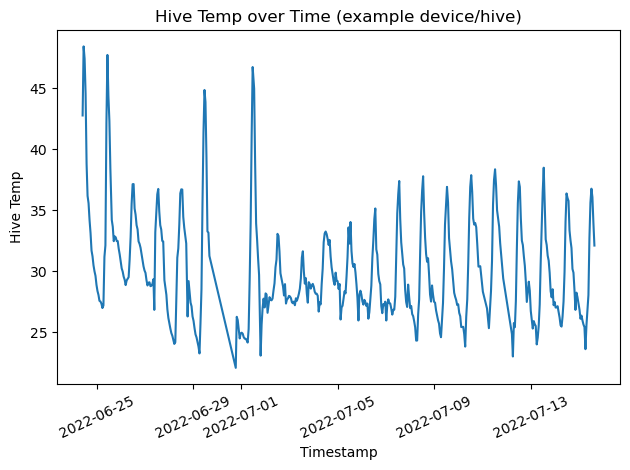

In [10]:
import matplotlib.pyplot as plt

example = df.dropna(subset=['device','hive_number']).copy()
if not example.empty:
    dev0 = int(example['device'].astype(float).astype(int).iloc[0])
    hive0 = int(example['hive_number'].astype(float).astype(int).iloc[0])
    ex = df[(df['device']==dev0) & (df['hive_number']==hive0)].sort_values('timestamp')
    if not ex.empty and 'hive_temp' in ex.columns:
        plt.figure()
        plt.plot(ex['timestamp'], ex['hive_temp'])
        plt.title('Hive Temp over Time (example device/hive)')
        plt.xlabel('Timestamp'); plt.ylabel('Hive Temp')
        plt.xticks(rotation=25)
        plt.tight_layout()

## 8) Optional feature windows (no files written)

In [11]:
from typing import List

GROUP_KEYS = ['device','hive_number']

def make_row_windows(data: pd.DataFrame, rows_per_window: int = 12, step: int = 6, numeric_cols: List[str] = None) -> pd.DataFrame:
    if numeric_cols is None:
        numeric_cols = ['hive_temp','hive_humidity','hive_pressure','weather_temp','weather_humidity','weather_pressure']
        numeric_cols = [c for c in numeric_cols if c in data.columns]
    out = []
    for _, grp in data.groupby(GROUP_KEYS, dropna=True):
        grp = grp.sort_values('timestamp').reset_index(drop=True)
        for start in range(0, max(len(grp) - rows_per_window + 1, 0), step):
            win = grp.iloc[start:start+rows_per_window]
            rec = {
                'device': win['device'].iloc[0],
                'hive_number': win['hive_number'].iloc[0],
                'start_ts': win['timestamp'].iloc[0],
                'end_ts': win['timestamp'].iloc[-1],
                'rows': len(win),
            }
            for c in numeric_cols:
                s = pd.to_numeric(win[c], errors='coerce')
                rec[f'{c}_mean'] = s.mean()
                rec[f'{c}_std'] = s.std()
                rec[f'{c}_min'] = s.min()
                rec[f'{c}_max'] = s.max()
            if 'queen_status' in win.columns:
                mode = win['queen_status'].dropna().mode()
                rec['queen_status_mode'] = mode.iloc[0] if len(mode) else np.nan
            out.append(rec)
    return pd.DataFrame(out)

def make_time_windows(data: pd.DataFrame, window: str = '3H', step: str = '1H', numeric_cols: List[str] = None) -> pd.DataFrame:
    if numeric_cols is None:
        numeric_cols = ['hive_temp','hive_humidity','hive_pressure','weather_temp','weather_humidity','weather_pressure']
        numeric_cols = [c for c in numeric_cols if c in data.columns]
    assert 'timestamp' in data.columns, 'timestamp required'
    out = []
    for _, grp in data.groupby(GROUP_KEYS, dropna=True):
        g = grp.sort_values('timestamp').set_index('timestamp')
        if g.empty:
            continue
        start = g.index.min()
        stop = g.index.max()
        t = start
        while t <= stop:
            win = g.loc[t : t + pd.Timedelta(window)]
            if len(win) > 0:
                rec = {
                    'device': win['device'].iloc[0],
                    'hive_number': win['hive_number'].iloc[0],
                    'start_ts': win.index.min(),
                    'end_ts': win.index.max(),
                    'rows': len(win),
                }
                for c in numeric_cols:
                    s = pd.to_numeric(win[c], errors='coerce')
                    rec[f'{c}_mean'] = s.mean()
                    rec[f'{c}_std'] = s.std()
                    rec[f'{c}_min'] = s.min()
                    rec[f'{c}_max'] = s.max()
                if 'queen_status' in win.columns:
                    mode = win['queen_status'].dropna().mode()
                    rec['queen_status_mode'] = mode.iloc[0] if len(mode) else np.nan
                out.append(rec)
            t = t + pd.Timedelta(step)
    return pd.DataFrame(out)

# Example usage (commented):
# row_feats = make_row_windows(df, rows_per_window=12, step=6)
# display(row_feats.head())
# time_feats = make_time_windows(df, window='3H', step='1H')
# display(time_feats.head())

## 9) Next steps

- Extend feature engineering inside the windowing helpers.
- Build time-aware train/validation splits per hive to avoid leakage.
